In [60]:
import argparse
import json
import logging
import sys

import copy
import numpy as np
import pandas as pd
import pdb

import glob
import os
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

import loki
from loki.util import constraints, postprocessing
from loki.solver import sat

# Setting up parameters

In [61]:
os.chdir("/flash1/pari/loki")
parser = argparse.ArgumentParser(description='Run Loki.')
parser.add_argument('--config', '-c', default='application.conf')
parser.add_argument('--workload', '-w', default='imdb')
parser.add_argument('--table', '-t', default='n')
parser.add_argument('--vars_per_col', '-n', default=1000)
parser.add_argument('--logfile', '-lf', default='logs/loki.log')
parser.add_argument('--verbose', '-v', default=False, action='store_true')
#args = parser.parse_args()
args = parser.parse_args(args=[])

# Input Files (IR of Parsed Query Workload)

In [62]:
loki.load_config(args.config)
c_df = pd.read_csv(loki.config[args.workload]['constraints_df'])
c_df.head(5)

,exprhash,RowCount,InputCardinality,RowSql,Column,input,jobid,Op,Value,Selectivity
56951,850796453869483752278881957410550970896541631110,1,12,SELECT COUNT(*) from role_type AS rt WHERE rt....,rt.role,rt,2228,=,'actress',8.333333e-02
29888,912859537000075986988044239092098240296557539121,30730,14835720,SELECT COUNT(*) from movie_info AS mi1 WHERE m...,mi1.info,mi,1149,like,'%swe%',2.071352e-03
78255,116365518962519389578875948095585004314774826390,2,2528312,SELECT COUNT(*) from title AS t WHERE t.produc...,t.production_year|t.title,t,3025,<=|=,2015|'The New Americans',7.910416e-07
63677,816686639207726275069471927608583471888058257065,0,2528312,SELECT COUNT(*) from title AS t WHERE t.produc...,t.production_year|t.title,t,2464,<=|=,1975|'A Midsummer Nights Dream',0.000000e+00
7140,323188010857736951103909548580603764386980023893,1,7,SELECT COUNT(*) from kind_type AS kt WHERE kt....,kt.kind,kt,267,=,'video game',1.428571e-01


# Converting the cardinalities ---> SAT constraints, and solving it for a potential database that satisfies those constraints

In [63]:
logging.basicConfig(
    level=logging.DEBUG if args.verbose else logging.INFO,
    format="%(asctime)s %(levelname)-8s [%(name)s]  %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    handlers=[logging.FileHandler(args.logfile), logging.StreamHandler()])

logger = logging.getLogger('stdout')

logger.info('Loki initialized with configuration:\n%s' % json.dumps(loki.config, sort_keys=True, indent=4))

df = pd.read_csv(loki.config[args.workload]['df'])
tables = set(df['input'])
table_columns = {table: set(df['column'].where(df['input'] == table).dropna()) for table in tables}

table = args.table
orig_table = table
# table = '"{}"'.format(table)

columns = table_columns[table]

constraints_df = constraints.get_constraints_df(c_df, table)
print("Operators used: ", set(constraints_df["Op"]))

table_cardinality = constraints.get_table_cardinality(constraints_df)
co_optimized_columns = constraints.get_co_optimized_columns(constraints_df, columns)
programs = constraints.get_programs(co_optimized_columns)

leftover_constraints = []

vars_per_col = args.vars_per_col

solutions = []

constraints_df = constraints_df[constraints_df["Value0"] != "None"]
constraints_df = constraints_df[constraints_df["Value1"] != "None"]
constraints_df = constraints_df[constraints_df["Value"] != "None"]
# pdb.set_trace()
for program in programs:
    logger.info(f'Solving: {program}')
    constraints_ = constraints.parse_constraints(program, constraints_df)
    model, vars, cols, col_values_ids_map = sat.build_model(program, constraints_, leftover_constraints, table_cardinality, vars_per_col)
    solution = sat.solve(model, vars, cols, col_values_ids_map, vars_per_col)
    solutions.append(solution)
    logger.info(f'Solved: {program}')


# Combine all programs' solutions into a single dictionary solution
full_solution = {k: v for s in solutions for k, v in s.items()}

postprocessing.apply_leftover_constraints(full_solution, leftover_constraints)
solution_df = postprocessing.solution_to_df(full_solution)
final_solution_df = postprocessing.scale_solution_df(solution_df, table_cardinality, vars_per_col)

final_solution_df.to_csv(f'results/{orig_table}.csv')

logger.info('Exiting Loki!')


2022-10-21 00:47:10 INFO     [stdout]  Loki initialized with configuration:
{
    "imdb": {
        "constraints_df": "sample-data/literal_df.csv",
        "df": "sample-data/op_df.csv"
    }
}
/flash1/pari/loki/loki/util/constraints.py:23: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for row in constraints_df[constraints_df.columns & [f'Column{i}' for i in range(max_cols)]].iterrows():
2022-10-21 00:47:11 INFO     [stdout]  Solving: {'gender', 'name_pcode_nf', 'name_pcode_cf', 'surname_pcode'}


Operators used:  {'=', 'like', '=|='}
Problem scale: 423000
Status = OPTIMAL


2022-10-21 00:47:57 INFO     [stdout]  Solved: {'gender', 'name_pcode_nf', 'name_pcode_cf', 'surname_pcode'}
2022-10-21 00:47:57 INFO     [stdout]  Solving: {'name'}


Problem scale: 17000


2022-10-21 00:47:59 INFO     [stdout]  Solved: {'name'}


Status = OPTIMAL


2022-10-21 00:48:06 INFO     [stdout]  Exiting Loki!


# Exploring the solution

In [64]:
final_solution_df.head(100)

,gender,name_pcode_nf,name_pcode_cf,surname_pcode,name
0,m,K6235,F6532,A625,%par%
1,m,K6235,F6532,A625,%par%
2,m,K6235,F6532,A625,%par%
3,m,K6235,F6532,A625,%par%
4,m,K6235,F6532,A625,%par%
...,...,...,...,...,...
95,m,K6235,F6532,A625,%par%
96,m,K6235,F6532,A625,%par%
97,m,K6235,F6532,A625,%par%
98,m,K6235,F6532,A625,%par%


# Uploading the created table to Postgres (skipping this step)

In [67]:
import sys
import os

os.chdir("/spinning/pari/WorkloadCharacterization")

try:
    os.rmdir("./new_results")
except Exception as e:
    pass

try:
    os.mkdir("./new_results")
except:
    pass

NUMQ = 200

# Executing Workload Queries on true data

In [68]:
CMD = "python3 eval_data.py --data_kind true_cols --num_queries {} \
--inp_to_eval n --port 5432 --workload ceb --db_name imdb --result_dir new_results".format(NUMQ)
os.system(CMD)

data/ceb-all/sqls/dfs/expr_df.csv
Number of sqls to evaluate: 200
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('m')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('f','m') AND n.name_pcode_nf in ('C6231','E4213','F6362','F6525','J513','M6251','M6263','P3625','R1632','R1636','R2631','R2632','S2153')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('m')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('f')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('m') AND n.name_pcode_nf in ('A6361','D1326','D1352','G6262','J5241','J5245','J5263','L2142','M6216','S3151')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('f','m')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('f','m')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('f') AND n.surname_pcode in ('B2','B6','B62','B653','C2','C5','J52','J525','L15','L52','M62','P62','R3','W425')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('f','m') AND n.name_pcode_nf 

SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('f') AND n.name_pcode_nf in ('A4253','A514','A5143','A5164','D5242','D5262','H4526','J5265','K6526','M6325','N2426','R2414','S1525','S2523','S6532')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('f') AND n.name_pcode_nf in ('A5242','K6235')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('m')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('m') AND n.name_pcode_nf in ('A6362','B6563','E3632','F6523','F6524','F6526','F6532','H6163','R1635','R1636','S2534','V4356')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('m')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('m')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('m') AND n.name_pcode_nf in ('A6362','B6563','E3632','F6362','F6523','F6524','F6526','F6532','G6216','H6163','R1635','R1636','R2632','S2534','W4362')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('m')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender 

0

# Executing Workload Queries on our Generated Data

In [69]:
CMD2 = "python3 eval_data.py --data_kind gen_shuffle --num_queries {} \
--inp_to_eval n --port 5432 --workload ceb --db_name imdb --result_dir new_results".format(NUMQ)
os.system(CMD2)

data/ceb-all/sqls/dfs/expr_df.csv
Number of sqls to evaluate: 200
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('m')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('f','m') AND n.name_pcode_nf in ('C6231','E4213','F6362','F6525','J513','M6251','M6263','P3625','R1632','R1636','R2631','R2632','S2153')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('m')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('f')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('m') AND n.name_pcode_nf in ('A6361','D1326','D1352','G6262','J5241','J5245','J5263','L2142','M6216','S3151')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('f','m')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('f','m')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('f') AND n.surname_pcode in ('B2','B6','B62','B653','C2','C5','J52','J525','L15','L52','M62','P62','R3','W425')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('f','m') AN

SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('f')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('f','m') AND n.name_pcode_nf in ('E4213','F6362','J513','M6251','M6263','P3625','R1631','R1632','R1636','R2631','R2632','S2153')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('m')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('f') AND n.name_pcode_nf in ('A4253','A514','A5143','A5164','D5242','D5262','H4526','J5265','K6526','M6325','N2426','R2414','S1525','S2523','S6532')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('f') AND n.name_pcode_nf in ('A5242','K6235')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('m')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('m') AND n.name_pcode_nf in ('A6362','B6563','E3632','F6523','F6524','F6526','F6532','H6163','R1635','R1636','S2534','V4356')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in ('m')
SELECT COUNT(*) from n_gen_shuffle AS n WHERE n.gender in 

0

# Exploring the results

In [76]:
def extract_val(d, key):
    val_start = d.find(key)
    val_end = val_start + d[val_start:].find(",")
    if val_end < val_start:
        val_end = val_start + d[val_start:].find(")")
    val = d[val_start:val_end].split("=")[1]
    return val.replace("'", "")

def load_logs(logfile):
    with open(logfile, "r") as f:
        data = f.readlines()
    
    retdata = defaultdict(list)
    alg = None
    #port = None
    
    for d in data:
        if "data_kind" in d:
            #d = d.replace("\n", "")
            #d = d.replace(" ", "")
            data_kind = extract_val(d, "data_kind")
            inp_to_eval = extract_val(d, "inp_to_eval")
            nq = int(extract_val(d, "num_queries"))
            wk = extract_val(d, "workload")
            if "port" not in d:
                break
            
            port = int(extract_val(d, "port"))
            skip_likes = int(extract_val(d, "skip_likes"))
            
        if "-->" in d:
            linedata = d.split(" ")
            ehash = linedata[5]
            rt = float(linedata[-1].replace("\n", ""))
            rep = int(linedata[-5])
            qerr = float(linedata[-3].replace("QErr:", ""))
            
            retdata["ehash"].append(ehash)
            retdata["rt"].append(rt)
            retdata["rep"].append(rep)
            retdata["data_kind"].append(str(data_kind))
            retdata["inp_to_eval"].append(inp_to_eval)
            retdata["num_queries"].append(nq)
            retdata["workload"].append(wk)
            retdata["port"].append(port)
            retdata["skip_likes"].append(skip_likes)
            retdata["qerr"].append(qerr)
            
    df = pd.DataFrame(retdata)
    return df

In [77]:
LOGDIR = "./new_results/"
fns = glob.glob(LOGDIR + "*.log")
dfs = []

for fn in fns:
    df = load_logs(fn)
    dfs.append(df)
df = pd.concat(dfs)

In [78]:
mapping = {}
mapping["true_cols"] = "True Data"
mapping["gen_shuffle"] = "Generated Data"

df["data_kind"] = df.apply(lambda x: mapping[x["data_kind"]] , axis=1)

In [79]:
tmp = df.groupby(["ehash", "data_kind"])[["rt"]].mean().reset_index()
edf = tmp.set_index(['ehash', 'data_kind'])['rt'].unstack().reset_index()

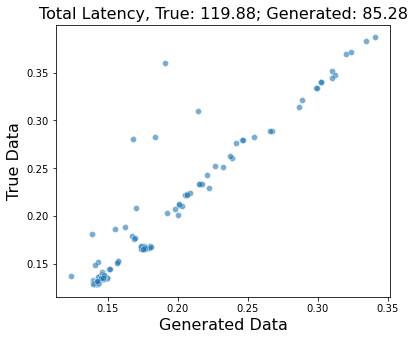

In [80]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,5))
true_rt = round(df.groupby(["data_kind"])["rt"].sum()["True Data"], 2)
gen_rt = round(df.groupby(["data_kind"])["rt"].sum()["Generated Data"], 2)

title = "Total Latency, True: {}; Generated: {}".format(true_rt, gen_rt)

sns.scatterplot(data=edf, x = "Generated Data", y="True Data", alpha=0.6, ax=ax)

ax.set_ylabel("True Data", fontsize=16)
ax.set_xlabel("Generated Data", fontsize=16)

plt.title(title, fontsize=16)

#FN= "{}-{}-scatterplot.pdf".format(INP , NUMQ)
#plt.savefig(FN, bbox_inches="tight")
plt.show()